In [1]:
#importacion de librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.datasets import  fashion_mnist

2023-07-24 05:52:41.332107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#cargando el dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_test = X_train/255, X_test/255


In [ ]:
#aplicando el desenfocado promedio
def add_noise(X):
    res = []
    for pic in X:
        blur = cv2.blur(pic, (3, 3))
        blur = np.clip(blur, 0, 1)
        res.append(blur)
    return np.array(res)
noise_train = add_noise(X_train)
noise_test = add_noise(X_test)

In [3]:
#contruyendo el modelo
from keras import models, layers
model = models.Sequential()
#encode
model.add(layers.Conv2D(64, (2, 2), strides = 1, padding = 'same', input_shape = (28, 28, 1)))
model.add(layers.Conv2D(32, (2, 2), strides = 1, padding = 'same'))
model.add(layers.Conv2D(16, (2, 2), strides = 1, padding = 'same'))
#latent
model.add(layers.Conv2D(8, (2, 2), strides = 1, padding = 'same'))
#decode
model.add(layers.Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same'))
model.add(layers.Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same'))
model.add(layers.Conv2DTranspose(64, (2, 2), strides = 1, padding = 'same'))
model.add(layers.Conv2DTranspose(1, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same'))

2023-07-23 07:27:45.647933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 07:27:45.671855: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
#entrenando el modelo
model.compile(loss = 'mse', optimizer = 'adam')
model.fit(noise_train.reshape(-1, 28, 28, 1), 
          X_train.reshape(-1, 28, 28, 1), 
          epochs = 100, 
          batch_size = 2000, 
          validation_data = (noise_test.reshape(-1  , 28, 28, 1),X_test.reshape(-1, 28, 28, 1)))

model.save("model-d_promedio.h5")

Epoch 1/100
30/30 [==============================] - 169s 6s/step - loss: 0.0553 - val_loss: 0.0226
Epoch 2/100
30/30 [==============================] - 140s 5s/step - loss: 0.0180 - val_loss: 0.0154
Epoch 3/100
30/30 [==============================] - 122s 4s/step - loss: 0.0132 - val_loss: 0.0112
Epoch 4/100
30/30 [==============================] - 128s 4s/step - loss: 0.0097 - val_loss: 0.0086
Epoch 5/100
30/30 [==============================] - 179s 6s/step - loss: 0.0082 - val_loss: 0.0078
Epoch 6/100
30/30 [==============================] - 168s 6s/step - loss: 0.0074 - val_loss: 0.0072
Epoch 7/100
30/30 [==============================] - 225s 8s/step - loss: 0.0070 - val_loss: 0.0075
Epoch 8/100
30/30 [==============================] - 175s 6s/step - loss: 0.0067 - val_loss: 0.0065
Epoch 9/100
30/30 [==============================] - 171s 6s/step - loss: 0.0063 - val_loss: 0.0062
Epoch 10/100
30/30 [==============================] - 132s 4s/step - loss: 0.0061 - val_loss: 0.0060

In [3]:
#cargando el modelo
model = keras.models.load_model('model-d_promedio.h5')

#viendo la arquitectura del modelo
model.summary()

2023-07-24 05:54:36.656275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 05:54:36.966583: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        8224      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        2064      
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 8)         520       
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 16)       528       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       2080      
 ranspose)                                              

1/1 [==============================] - 0s 102ms/step
Original Images


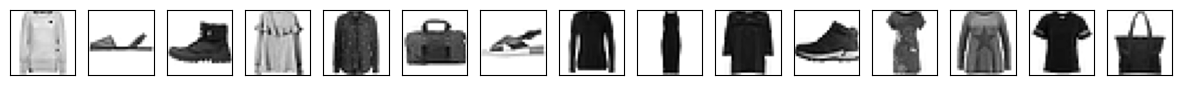

Blurred Images


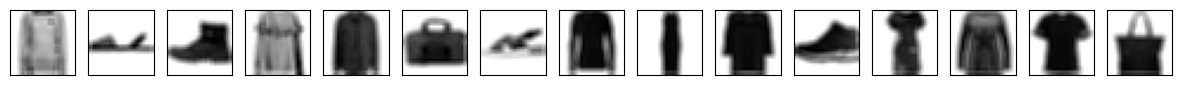

Predicted Images


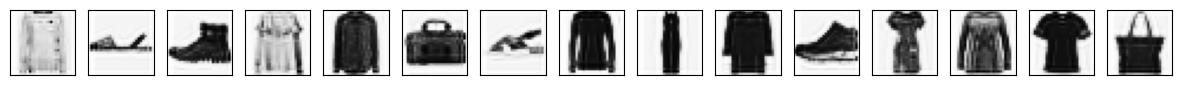

<Figure size 640x480 with 0 Axes>

In [9]:
import random
#utility function to pick samples to be tested
def get_samples(arr, n):
    temp = random.sample(range(len(arr)), n)
    result = arr[temp]
    return result, temp
num = 15
org, temp = get_samples(X_test, num)
blur = noise_test[temp]
preds = model.predict(blur.reshape(-1, 28, 28, 1))
preds = preds.reshape(-1, 28, 28)
#plotting results
plt.figure(figsize = (15, 15))
print('Original Images')
for i in range(num):
    plt.subplot(1, num, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(org[i], cmap=plt.cm.binary)
plt.show()
plt.figure(figsize = (15, 15))
print('Blurred Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(blur[i], cmap=plt.cm.binary)
plt.show()
plt.figure(figsize = (15, 15))
print('Predicted Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i], cmap=plt.cm.binary)
plt.show()


(-0.5, 27.5, 27.5, -0.5)

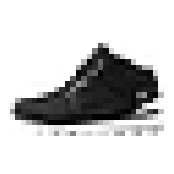

In [5]:
#1era imagen  original
plt.figure(figsize=(2,2))
plt.imshow(org[0], cmap='binary')
plt.axis(False)

(-0.5, 27.5, 27.5, -0.5)

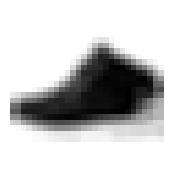

In [6]:
#1era imagen desfocada
plt.figure(figsize=(2,2))
plt.imshow(blur[0], cmap='binary')
plt.axis(False)

(-0.5, 27.5, 27.5, -0.5)

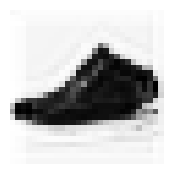

In [7]:
#1era imagen predecida
plt.figure(figsize=(2,2))
plt.imshow(preds[0], cmap='binary')
plt.axis(False)

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model


# Utilizar el modelo para predecir las imágenes reconstruidas
reconstructed_images = model.predict(noise_test.reshape(-1, 28, 28, 1))

# Calcular el error cuadrático medio (MSE) entre las imágenes reconstruidas y las imágenes originales
mse = np.mean(np.square(X_test.reshape(-1, 28, 28, 1) - reconstructed_images))

# Calcular el porcentaje de error con respecto al original
percentage_error = mse / np.mean(np.square(X_test.reshape(-1, 28, 28, 1)))

print(f"Porcentaje de error con respecto al original: {percentage_error:.2%}")

313/313 [==============================] - 14s 44ms/step
Porcentaje de error con respecto al original: 2.46%
